In [1]:
import os
import pandas as pd
import numpy as np

from rdkit import Chem
# suppress rdkit warning
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

from sklearn import metrics
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set_style("whitegrid")

In [2]:
def group_f1_b(df, thr=0.5): 
    label = np.array(df.Class_b.tolist(), dtype=int)
    pred = np.array(df.Pred_b.tolist(), dtype=float)
    pred = np.where(pred > thr, 1, 0)
    score = metrics.f1_score(label, pred, average='micro')
    return score

def group_kappa_b(df, thr=0.5): 
    label = np.array(df.Class_b.tolist(), dtype=int)
    pred = np.array(df.Pred_b.tolist(), dtype=float)
    pred = np.where(pred > thr, 1, 0)
    score = metrics.cohen_kappa_score(label, pred)
    return score

def group_acc_b(df, thr=0.5): 
    label = np.array(df.Class_b.tolist(), dtype=int)
    pred = np.array(df.Pred_b.tolist(), dtype=float)
    pred = np.where(pred > thr, 1, 0)
    score = metrics.accuracy_score(label, pred)
    return score

def group_auc_b(df): 
    label = np.array(df.Class_b.tolist(), dtype=int)
    pred = np.array(df.Pred_b.tolist(), dtype=float)
    try: 
        score = metrics.roc_auc_score(label, pred)
    except: 
        score = np.nan
    return score

In [3]:
from scipy.special import softmax

def binary_cls(cls):
    if cls == 0 or cls == 1:
        return 0
    elif cls == 2 or cls == 3:
        return 1
    else:
        return None
    
def binary_pred(pred):
    pred = np.array(pred.split(','), dtype=float)
    # pred_b = np.array([pred[0]+pred[1], pred[2]+pred[3]])
    # pred_b = softmax(pred_b)
    # return pred_b[1] # the probability to greater label
    return pred[2]+pred[3]

In [4]:
def convert2cls(chir, csp_category): 
    if csp_category == '1' or csp_category == 1: 
        # For polysaccharide CSPs:
        if chir < 1.15:
            y = 0
        elif chir < 1.2:
            y = 1
        elif chir < 2.1:
            y = 2
        else:
            y = 3
    elif csp_category == '2' or csp_category == 2: 
        # For Pirkle CSPs:
        if chir < 1.05: 
            y = 0
        elif chir < 1.15:
            y = 1
        elif chir < 2: 
            y = 2
        else:
            y = 3
    else:
        raise Exception("The category for CSP should be 1 or 2, rather than {}.".format(csp_category))
    return y

## 1. Load prediction results

In [5]:
# dfs = []
# for mb in range(18): 
#     dfs.append(pd.read_csv('../results1203/molnet_cmrt_cls_etkdg_csp{}.csv'.format(str(mb)), 
#                                sep='\t', index_col=0))
# df_pred = pd.concat(dfs, ignore_index=True)
    
# dfs_ena = []
# for mb in range(18): 
#     dfs_ena.append(pd.read_csv('../results0804/molnet_cmrt_cls_etkdg_csp{}-ena.csv'.format(str(mb)), 
#                                sep='\t', index_col=0))
# df_pred_ena = pd.concat(dfs_ena, ignore_index=True)

# df_pred['Pred_b'] = df_pred['Pred'].apply(binary_pred)
# df_pred_ena['Pred_b'] = df_pred_ena['Pred'].apply(binary_pred)

# df_pred = df_pred.merge(df_pred_ena[['Pred_b']], left_index=True, right_index=True)

# df_pred['Pred_b'] = df_pred.apply(lambda x: (x['Pred_b_x'] + x['Pred_b_y']) / 2, axis=1)

In [102]:
dfs = []
for mb in range(18): 
    dfs.append(pd.read_csv('../results1203/molnet_cmrt_cls_etkdg_csp{}-ena.csv'.format(str(mb)), 
                               sep='\t', index_col=0))
df_pred = pd.concat(dfs, ignore_index=True)
df_pred['Pred_b'] = df_pred['Pred_avg'].apply(binary_pred)

In [103]:
df_pred = df_pred.sort_values(['ID', 'SMILES', 'MB', 'Pred_b'], 
                              ascending=False).drop_duplicates(['ID', 'SMILES', 'MB'], 
                                                               keep='first').sort_index()

In [104]:
df_pred

,index,ID,SMILES,MB,Pred_avg,Pred,Pred_b
0,0,chira_000000,Cc1ccc(S(=O)(=O)C[C@@H](C)c2ccc(C(F)(F)F)cc2)cc1,0,"3.5035744e-05,0.99565226,0.0015167592,0.00279597","3.503574407659471e-05,0.9956522583961487,0.001...",0.004313
2,2,chira_000001,Cc1ccc(S(=O)(=O)C[C@H](C)c2ccc(C(F)(F)F)cc2)cc1,0,"4.658966e-08,0.99984944,0.0001501394,4.1661997...","4.658965835346862e-08,0.9998494386672974,0.000...",0.000151
4,4,chira_000002,Cc1ccc(S(=O)(=O)C[C@@H](C)c2ccc(Cl)cc2)cc1,0,"4.0609716e-08,0.9999943,5.7133648e-06,3.499094...","4.06097164784569e-08,0.9999942779541016,5.7133...",0.000006
6,6,chira_000003,Cc1ccc(S(=O)(=O)C[C@H](C)c2ccc(Cl)cc2)cc1,0,"2.3487344e-07,0.18349922,0.81650037,1.7693371e-07","2.348734398083252e-07,0.18349921703338623,0.81...",0.816501
8,8,chira_000004,Cc1ccc(S(=O)(=O)C[C@H]2CCCc3ccccc32)cc1,0,"0.012952342,0.976384,0.0010069526,0.009656752","0.012952341698110104,0.9763839840888977,0.0010...",0.010664
...,...,...,...,...,...,...,...
194606,10802,chira_005401,CC(=O)NN[C@@H](/C=C/c1ccccc1)c1ccc(C)cc1,17,"4.8413995e-06,5.271372e-06,0.9999831,6.7235283...","4.841399459110107e-06,5.271372174320277e-06,0....",0.999990
194608,10804,chira_005402,O=C1O[C@H](N(Cc2ccccn2)S(=O)(=O)c2ccccc2)c2ccc...,17,"0.007825473,1.8029355e-05,0.832063,0.16009346","0.007825473323464394,1.8029355487669818e-05,0....",0.992156
194610,10806,chira_005403,O=C1O[C@@H](N(Cc2ccccn2)S(=O)(=O)c2ccccc2)c2cc...,17,"6.72201e-05,2.5952908e-05,0.96299756,0.036909252","6.722009857185185e-05,2.5952907890314236e-05,0...",0.999907
194612,10808,chira_005404,COC(=O)C[C@@H](O)c1ccc(N(C)C)cc1,17,"0.6759215,0.000654291,0.32288063,0.00054361846","0.6759214997291565,0.0006542910123243928,0.322...",0.323424


## 2. Load CMRT

In [57]:
suppl = Chem.SDMolSupplier("../data/CMRT/cmrt_clean.sdf")
mols = [x for x in suppl if x is not None]

In [58]:
df_dict = {'SMILES': [], 'MB': [], 'K2/K1': [], 'Y': []}

for mol in mols: 
    if mol.HasProp('encode_mobile_phase'):
        mb = mol.GetProp('encode_mobile_phase')
    else:
        mb = 'unknown'
    smiles = Chem.MolToSmiles(mol)
    chir = round(float(mol.GetProp('k2/k1')), 4)
    y = convert2cls(chir, mol.GetProp('mobile_phase_category'))
    
    df_dict['SMILES'].append(smiles)
    df_dict['K2/K1'].append(chir)
    df_dict['MB'].append(mb)
    df_dict['Y'].append(y)

df_label = pd.DataFrame.from_dict(df_dict)

In [59]:
df_label = df_label.sort_values(['SMILES', 'MB', 'K2/K1'], 
                              ascending=False).drop_duplicates(['SMILES', 'MB'], 
                                                               keep='first').sort_index()

In [60]:
df_label

,SMILES,MB,K2/K1,Y
0,Cc1ccc(S(=O)(=O)C[C@@H](C)c2ccc(C(F)(F)F)cc2)cc1,16,0.7792,0
1,Cc1ccc(S(=O)(=O)C[C@H](C)c2ccc(C(F)(F)F)cc2)cc1,16,0.7792,0
2,Cc1ccc(S(=O)(=O)C[C@@H](C)c2ccc(Cl)cc2)cc1,16,0.3095,0
3,Cc1ccc(S(=O)(=O)C[C@H](C)c2ccc(Cl)cc2)cc1,16,0.3095,0
4,Cc1ccc(S(=O)(=O)C[C@H]2CCCc3ccccc32)cc1,0,2.7838,3
...,...,...,...,...
5401,CC(=O)NN[C@@H](/C=C/c1ccccc1)c1ccc(C)cc1,6,1.0833,1
5402,O=C1O[C@H](N(Cc2ccccn2)S(=O)(=O)c2ccccc2)c2ccc...,16,1.2459,2
5403,O=C1O[C@@H](N(Cc2ccccn2)S(=O)(=O)c2ccccc2)c2cc...,16,1.2459,2
5404,COC(=O)C[C@@H](O)c1ccc(N(C)C)cc1,16,1.1218,0


## 3. Merge

In [61]:
df_csp = pd.read_csv('../preprocess/chirality_stationary_phase_list.csv').dropna()

Convert isomer SMILES into regular SMILES

In [17]:
df_pred['SMILES_iso'] = df_pred['SMILES']
df_label['SMILES_iso'] = df_label['SMILES']

df_pred['SMILES'] = df_pred['SMILES'].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x), isomericSmiles=False))
df_label['SMILES'] = df_label['SMILES'].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x), isomericSmiles=False))

In [18]:
df_pred['MB'] = df_pred['MB'].astype(int)
df_label['MB'] = df_label['MB'].astype(int)

df_cmrt = df_pred.merge(df_label, on=['SMILES_iso', 'SMILES', 'MB'], how='right').dropna()
df_cmrt['Y_b'] = df_cmrt['Y'].apply(binary_cls)

df_cmrt0 = df_cmrt[df_cmrt['Y_b'] == 0]
df_cmrt1 = df_cmrt[df_cmrt['Y_b'] == 1]

df_cmrt0 = df_cmrt0.sort_values(['SMILES', 
                                 'MB', 
                                 'Pred_b'], ascending=False).drop_duplicates(['SMILES', 
                                                                              'MB'], keep='last').sort_index()

df_cmrt1 = df_cmrt1.sort_values(['SMILES', 
                                 'MB', 
                                 'Pred_b'], ascending=False).drop_duplicates(['SMILES', 
                                                                              'MB'], keep='first').sort_index()

df_cmrt = pd.concat([df_cmrt0, df_cmrt1])

In [19]:
df_cmrt

,index,ID,SMILES,MB,Pred_avg,Pred,Pred_b,SMILES_iso,K2/K1,Y,Y_b
0,0.0,chira_000000,Cc1ccc(S(=O)(=O)CC(C)c2ccc(C(F)(F)F)cc2)cc1,16,"0.9867438,0.01323874,9.211784e-06,8.2327e-06","0.9867438077926636,0.013238740153610706,9.2117...",0.000017,Cc1ccc(S(=O)(=O)C[C@@H](C)c2ccc(C(F)(F)F)cc2)cc1,0.7792,0,0
3,6.0,chira_000003,Cc1ccc(S(=O)(=O)CC(C)c2ccc(Cl)cc2)cc1,16,"0.8063273,0.19337755,0.00028174656,1.3464058e-05","0.8063272833824158,0.1933775544166565,0.000281...",0.000295,Cc1ccc(S(=O)(=O)C[C@H](C)c2ccc(Cl)cc2)cc1,0.3095,0,0
25,50.0,chira_000025,CC(CS(C)(=O)=O)c1ccccc1,14,"0.99165815,1.4080578e-05,0.008327798,1.3469386...","0.9916581511497498,1.4080577784625348e-05,0.00...",0.008328,C[C@@H](CS(C)(=O)=O)c1ccccc1,1.1754,1,0
41,82.0,chira_000041,CC(C#N)c1cccc2ccccc12,9,"9.692828e-13,1.315059e-12,1.0,7.1309924e-12","9.692828137342069e-13,1.3150589558280634e-12,1...",1.000000,C[C@H](C#N)c1cccc2ccccc12,1.1343,1,0
86,176.0,chira_000088,C#CC(C(=C)C(=O)OCc1ccccc1)c1ccc(F)cc1,8,"0.00012590873,0.99985266,9.963835e-06,1.145730...","0.00012590872938744724,0.9998526573181152,9.96...",0.000021,C#C[C@H](C(=C)C(=O)OCc1ccccc1)c1ccc(F)cc1,1.1170,1,0
...,...,...,...,...,...,...,...,...,...,...,...
5188,10774.0,chira_005387,COc1ccc(C(C=CC(=O)n2nc(C)c(C)c2C)N(C)Cc2ccccc2...,16,"4.0942012e-07,0.0004155421,0.9994821,0.0001020...","4.094201244697615e-07,0.00041554210474714637,0...",0.999584,COc1ccc([C@H](/C=C/C(=O)n2nc(C)c(C)c2C)N(C)Cc2...,1.3895,2,1
5190,10778.0,chira_005389,CCOC(=O)C1=C(c2ccc(OC)cc2)NC(=O)CC1C(F)(F)F,0,"0.13448992,0.38517267,0.11726516,0.3630722","0.13448992371559143,0.38517266511917114,0.1172...",0.480337,CCOC(=O)C1=C(c2ccc(OC)cc2)NC(=O)C[C@H]1C(F)(F)F,1.5388,2,1
5192,10782.0,chira_005391,CC1=NN(c2ccccc2)C(=O)C1(CC=Cc1ccccc1)Cc1ccccc1,16,"0.00011080696,0.0044066845,0.93232685,0.06315566","0.00011080696276621893,0.004406684543937445,0....",0.995483,CC1=NN(c2ccccc2)C(=O)[C@@]1(C/C=C/c1ccccc1)Cc1...,1.4980,2,1
5199,10796.0,chira_005398,CC1(Nc2ccccc2I)C(=O)Nc2ccccc21,0,"0.0026019614,0.0061408365,0.9903562,0.0009010809","0.0026019613724201918,0.006140836514532566,0.9...",0.991257,C[C@]1(Nc2ccccc2I)C(=O)Nc2ccccc21,1.4901,2,1


Exclude the overlapped samples between ChirBase and CMRT

In [20]:
df_overlap = pd.read_csv('../data/compare_chirbase_cmrt.csv')

df_overlap = df_overlap.sort_values(['SMILES', 'Column_x', 'K2/K1_x'], 
                              ascending=False).drop_duplicates(['SMILES', 'Column_x'], 
                                                               keep='first').sort_index()
df_overlap = df_overlap.merge(df_csp, left_on='Column_x', right_on='Short_Name', how='left')

df_nonoverlap = pd.merge(df_cmrt, df_overlap, 
                         left_on=['SMILES', 'MB'], right_on=['SMILES', 'CSP_Encode'], 
                         how='outer', indicator=True).query("_merge != 'both'").drop('_merge', axis=1).reset_index(drop=True)

In [21]:
df_nonoverlap

,index,ID,SMILES,MB,Pred_avg,Pred,Pred_b,SMILES_iso,K2/K1,Y,...,CSP_category,Y_x,Y_y,Y_x2,Y_y2,CSP,Short_Name,CSP_ID,CSP_Encode,CSP_Category
0,0.0,chira_000000,Cc1ccc(S(=O)(=O)CC(C)c2ccc(C(F)(F)F)cc2)cc1,16,"0.9867438,0.01323874,9.211784e-06,8.2327e-06","0.9867438077926636,0.013238740153610706,9.2117...",0.000017,Cc1ccc(S(=O)(=O)C[C@@H](C)c2ccc(C(F)(F)F)cc2)cc1,0.7792,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6.0,chira_000003,Cc1ccc(S(=O)(=O)CC(C)c2ccc(Cl)cc2)cc1,16,"0.8063273,0.19337755,0.00028174656,1.3464058e-05","0.8063272833824158,0.1933775544166565,0.000281...",0.000295,Cc1ccc(S(=O)(=O)C[C@H](C)c2ccc(Cl)cc2)cc1,0.3095,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,50.0,chira_000025,CC(CS(C)(=O)=O)c1ccccc1,14,"0.99165815,1.4080578e-05,0.008327798,1.3469386...","0.9916581511497498,1.4080577784625348e-05,0.00...",0.008328,C[C@@H](CS(C)(=O)=O)c1ccccc1,1.1754,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,82.0,chira_000041,CC(C#N)c1cccc2ccccc12,9,"9.692828e-13,1.315059e-12,1.0,7.1309924e-12","9.692828137342069e-13,1.3150589558280634e-12,1...",1.000000,C[C@H](C#N)c1cccc2ccccc12,1.1343,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,176.0,chira_000088,C#CC(C(=C)C(=O)OCc1ccccc1)c1ccc(F)cc1,8,"0.00012590873,0.99985266,9.963835e-06,1.145730...","0.00012590872938744724,0.9998526573181152,9.96...",0.000021,C#C[C@H](C(=C)C(=O)OCc1ccccc1)c1ccc(F)cc1,1.1170,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2441,10774.0,chira_005387,COc1ccc(C(C=CC(=O)n2nc(C)c(C)c2C)N(C)Cc2ccccc2...,16,"4.0942012e-07,0.0004155421,0.9994821,0.0001020...","4.094201244697615e-07,0.00041554210474714637,0...",0.999584,COc1ccc([C@H](/C=C/C(=O)n2nc(C)c(C)c2C)N(C)Cc2...,1.3895,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2442,10778.0,chira_005389,CCOC(=O)C1=C(c2ccc(OC)cc2)NC(=O)CC1C(F)(F)F,0,"0.13448992,0.38517267,0.11726516,0.3630722","0.13448992371559143,0.38517266511917114,0.1172...",0.480337,CCOC(=O)C1=C(c2ccc(OC)cc2)NC(=O)C[C@H]1C(F)(F)F,1.5388,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2443,10782.0,chira_005391,CC1=NN(c2ccccc2)C(=O)C1(CC=Cc1ccccc1)Cc1ccccc1,16,"0.00011080696,0.0044066845,0.93232685,0.06315566","0.00011080696276621893,0.004406684543937445,0....",0.995483,CC1=NN(c2ccccc2)C(=O)[C@@]1(C/C=C/c1ccccc1)Cc1...,1.4980,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2444,10796.0,chira_005398,CC1(Nc2ccccc2I)C(=O)Nc2ccccc21,0,"0.0026019614,0.0061408365,0.9903562,0.0009010809","0.0026019613724201918,0.006140836514532566,0.9...",0.991257,C[C@]1(Nc2ccccc2I)C(=O)Nc2ccccc21,1.4901,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Calculate metrics (AUC, ACC, KAPPA, F1, COUNT)

In [22]:
df_nonoverlap['Class_b'] = df_nonoverlap['Y'].apply(binary_cls)

In [23]:
auc = df_nonoverlap.groupby('MB').apply(group_auc_b)
acc = df_nonoverlap.groupby('MB').apply(group_acc_b)
kappa = df_nonoverlap.groupby('MB').apply(group_kappa_b)
f1 = df_nonoverlap.groupby('MB').apply(group_f1_b)
cnt = df_nonoverlap.groupby('MB').size()

In [24]:
df_res_all = pd.concat([auc, acc, kappa, f1, cnt], names=['AUC', 'ACC', 'KAPPA', 'F1', 'COUNT'], axis=1)
df_res_all.reset_index(inplace=True)
df_res_all = df_res_all.rename(columns = {'index': 'MB', 0: 'AUC', 1: 'ACC', 2: 'KAPPA', 3: 'F1', 4: 'COUNT'})

df_res_all = df_res_all.merge(df_csp, left_on='MB', right_on='CSP_Encode')

In [25]:
df_res_all

,MB,AUC,ACC,KAPPA,F1,COUNT,CSP,Short_Name,CSP_ID,CSP_Encode,CSP_Category
0,0,0.617281,0.714789,0.077182,0.714789,284,Chiralpak IB,IB,91423,0,2
1,6,0.733796,0.804124,0.187031,0.804124,97,Chiralcel OJ (Lux Cellulose-3),OJ,90246,6,2
2,8,0.719246,0.784810,0.181098,0.784810,158,Chiralcel OD (Lux Cellulose-1),OD,45173,8,2
3,9,0.671024,0.654676,0.132605,0.654676,139,Chiralpak AS,AS,45167,9,2
4,11,0.844544,0.851852,0.461595,0.851852,243,Chiralpak AD,AD,23735,11,2
5,14,0.718677,0.682868,0.303621,0.682868,823,Chiralpak IC (Sepapak 5),IC,91518,14,1
6,16,0.699932,0.668091,0.293860,0.668091,702,Chiralpak IA,IA,45172,16,1


In [26]:
# with pd.ExcelWriter('test_cmrt.xlsx') as writer:  
#     df_res_all.to_excel(writer, sheet_name='all')
#     df_res_overlap.to_excel(writer, sheet_name='overlap')

## 4. Load the results of cross-validation on ChirBase

In [38]:
dfs = []
for mb in range(18): 
    for i in range(5):
        dfs.append(pd.read_csv('../results1203/molnet_chirality_cls_etkdg_csp{}-5fold_tl_{}.csv'.format(str(mb), str(i)), 
                               sep='\t', index_col=0))
df_chirbase = pd.concat(dfs, ignore_index=True)

df_chirbase['Class_b'] = df_chirbase['Class'].apply(binary_cls)
df_chirbase['Pred_b'] = df_chirbase['Pred'].apply(binary_pred)

In [39]:
auc = df_chirbase.groupby('MB').apply(group_auc_b)
acc = df_chirbase.groupby('MB').apply(group_acc_b)
kappa = df_chirbase.groupby('MB').apply(group_kappa_b)
f1 = df_chirbase.groupby('MB').apply(group_f1_b)
cnt = df_chirbase.groupby('MB').size()

In [40]:
df_res_cv = pd.concat([auc, acc, kappa, f1, cnt], names=['AUC', 'ACC', 'KAPPA', 'F1', 'COUNT'], axis=1)
df_res_cv.reset_index(inplace=True)
df_res_cv = df_res_cv.rename(columns = {'index': 'MB', 0: 'AUC', 1: 'ACC', 2: 'KAPPA', 3: 'F1', 4: 'COUNT'})

df_res_cv = df_res_cv.merge(df_csp, left_on='MB', right_on='CSP_Encode')

In [106]:
df_res_cv

,MB,AUC,ACC,KAPPA,F1,COUNT,CSP,Short_Name,CSP_ID,CSP_Encode,CSP_Category,Label
0,0,0.947577,0.924060,0.820114,0.924060,1330,Chiralpak IB,IB,91423,0,2,Cross validation on ChirBase
1,6,0.851587,0.910241,0.752108,0.910241,8300,Chiralcel OJ (Lux Cellulose-3),OJ,90246,6,2,Cross validation on ChirBase
2,8,0.844038,0.913925,0.741619,0.913925,27360,Chiralcel OD (Lux Cellulose-1),OD,45173,8,2,Cross validation on ChirBase
3,9,0.842391,0.912971,0.723982,0.912971,7170,Chiralpak AS,AS,45167,9,2,Cross validation on ChirBase
4,11,0.832335,0.901336,0.715342,0.901336,21700,Chiralpak AD,AD,23735,11,2,Cross validation on ChirBase
5,14,0.830561,0.864039,0.673767,0.864039,2030,Chiralpak IC (Sepapak 5),IC,91518,14,1,Cross validation on ChirBase
6,16,0.854548,0.850746,0.667058,0.850746,2680,Chiralpak IA,IA,45172,16,1,Cross validation on ChirBase


### Plot!!

In [42]:
def plot_roc_curve_b(pred, target, name=None, save_fig=False, print_confusion_metrics=False): 
    f, ax = plt.subplots(figsize=(6, 6))

    fpr, tpr, thresh = metrics.roc_curve(target, pred)
    auc = metrics.roc_auc_score(target, pred)
    ax.plot(fpr, tpr, label="super-class 1 vs the rest (AUC={:.2f})".format(auc))

    ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    ax.axis("square")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("CSP {}".format(name))
    ax.legend()

    if save_fig: 
        plt.savefig('./roc_curve_{}.png'.format(str(mb_idx)), dpi=300, bbox_inches='tight')
        print('Save!')
    plt.show()
    
    # confusion metrics
    if print_confusion_metrics: 
        pred = np.argmax(pred_prob, axis=1)
        print('confusion metrics: \n[[tn, fp], \n[fn, tp]]\n')
        print(metrics.multilabel_confusion_matrix(df_tmp['Class'].to_numpy(), pred))

In [43]:
# plot_roc_curve_b(df_cmrt['Pred_b'], df_cmrt['Class_b'], name='All')

In [44]:
# grouped = df_cmrt.groupby('MB')

# for name, group in grouped: 
#     print(len(group), len(group[group['Class_b']==1]))
#     plot_roc_curve_b(group['Pred_b'], group['Class_b'], name)

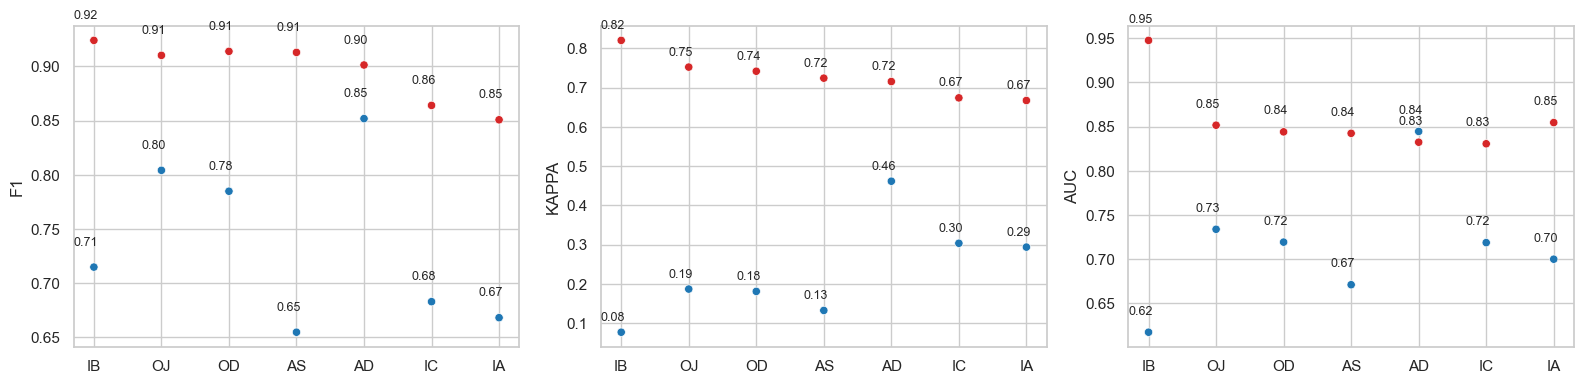

In [45]:
CSP_dict = {'IB': 0, 'OJ': 1, 'OD': 2, 'AS': 3, 'AD': 4, 'IC': 5, 'IA': 6}
# CSP_dict = {'OD': 0, 'AS': 1, 'AD': 2, 'IC': 3, 'IA': 4}
# IB: do not have overlap
# OJ: only have one positive sample
# OD: no positive samples

fig, axs = plt.subplots(1, 3, figsize=(16, 4))

df_res_all['Label'] = 'Test on CMRT'
df_res_cv['Label'] = 'Cross validation on ChirBase'
df_res = pd.concat([df_res_all, df_res_cv])
df_res_plot = df_res[df_res['Short_Name'].isin(CSP_dict.keys())]

sns.scatterplot(data=df_res_plot, x="Short_Name", y="AUC", hue='Label', 
                ax=axs[2], legend=False, palette=['tab:blue', 'tab:red'])
axs[2].set(xlabel=None)

sns.scatterplot(data=df_res_plot, x="Short_Name", y="KAPPA", hue='Label', 
                ax=axs[1], legend=False, palette=['tab:blue', 'tab:red'])
axs[1].set(xlabel=None)

sns.scatterplot(data=df_res_plot, x="Short_Name", y="F1", hue='Label', 
                ax=axs[0], legend=False, palette=['tab:blue', 'tab:red'])
axs[0].set(xlabel=None)


for i, point in df_res_plot.iterrows(): 
    axs[2].text(CSP_dict[point['Short_Name']]-0.3, point['AUC']+0.02, '{:.2f}'.format(point['AUC']), fontsize=9)
    axs[1].text(CSP_dict[point['Short_Name']]-0.3, point['KAPPA']+0.03, '{:.2f}'.format(point['KAPPA']), fontsize=9)
    axs[0].text(CSP_dict[point['Short_Name']]-0.3, point['F1']+0.02, '{:.2f}'.format(point['F1']), fontsize=9)
    
fig.tight_layout()
plt.savefig('./test_cmrt_all1203.eps', dpi=600, bbox_inches='tight', format='eps')
plt.savefig('./test_cmrt_all1203.png', dpi=600, bbox_inches='tight')
plt.show()

## 5. Compare with qGeoGNN

In [142]:
dfs = []
qgeognn_res_path = '/home/yuhhong/qGeoGNN_rt/results/'
files_list = [f for f in os.listdir(qgeognn_res_path) if not f.endswith('_post.csv')]

for f in files_list:
    df_tmp = pd.read_csv(os.path.join(qgeognn_res_path, f), sep='\t', index_col=0)
    df_tmp['Column'] = f.replace('.csv', '')
    dfs.append(df_tmp)

df_qgeognn = pd.concat(dfs)

df_qgeognn = df_qgeognn[['SMILES', 'Column', 'Y_Pred']]

In [143]:
data_dfs = []
for csp in ['ADH', 'ODH', 'OJ', 'OD', 'AS', 'AD', 'IA', 'IC']:
    df_tmp = pd.read_csv('/home/yuhhong/qGeoGNN_rt/dataset/{}_charity_0823.csv'.format(csp), index_col=0)
    data_dfs.append(df_tmp)
    
df_qgeognn_data = pd.concat(data_dfs)

df_qgeognn_data = df_qgeognn_data.drop(['Unnamed: 0'], axis=1)

df_qgeognn_data = df_qgeognn_data[['index', 'SMILES', 'RT', 'Speed', 'Column']]

In [144]:
df_qgeognn = df_qgeognn.merge(df_qgeognn_data, on=['SMILES', 'Column'], how='left')

In [145]:
grouped = df_qgeognn.groupby(by=['index', 'Column'])
df1 = grouped.filter(lambda x: len(x) == 1)
df2 = grouped.filter(lambda x: len(x) > 1)

Half predicted & half labeled 

In [146]:
df1 = df_qgeognn_data[df_qgeognn_data['index'].isin(df1['index'])].merge(df1, on=['index', 'Column'], how='right')

df1 = df1[df1['SMILES_x'] != df1['SMILES_y']]

df1['RT_Pred'] = df1.apply(lambda x: x['Y_Pred']/x['Speed_y'], axis=1)

df1 = df1[(df1['RT_x'] != 0) & (df1['RT_y'] != 0) & (df1['RT_Pred'] != 0)]

df1['K2/K1'] = df1.apply(lambda x: (max(x['RT_x'], x['RT_y']) - 2.9) / (min(x['RT_x'], x['RT_y']) - 2.9), axis=1)
df1['K2/K1_Pred'] = df1.apply(lambda x: (max(x['RT_x'], x['RT_Pred']) - 2.9) / (min(x['RT_x'], x['RT_Pred']) - 2.9), axis=1)

In [147]:
df1 = df1.merge(df_csp, left_on='Column', right_on='Short_Name', how='left').dropna()
df1['Pred_qgeognn'] = df1.apply(lambda x: convert2cls(x['K2/K1_Pred'], x['CSP_Category']), axis=1)
df1['Pred_qgeognn_b'] = df1['Pred_qgeognn'].apply(binary_cls)

df1.reset_index(drop=True, inplace=True)

In [148]:
df1['SMILES'] = df1['SMILES_x'].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x), isomericSmiles=False))

In [149]:
df1 = df1.merge(df_cmrt, left_on=['SMILES', 'CSP_Encode'], right_on=['SMILES', 'MB'], how='inner')

In [150]:
len(df1)

248

qGeoGNN
F1: 0.6209677419354839
KAPPA: 0.2003293084522504
ACC: 0.6209677419354839

positive: 66%, negative: 33%


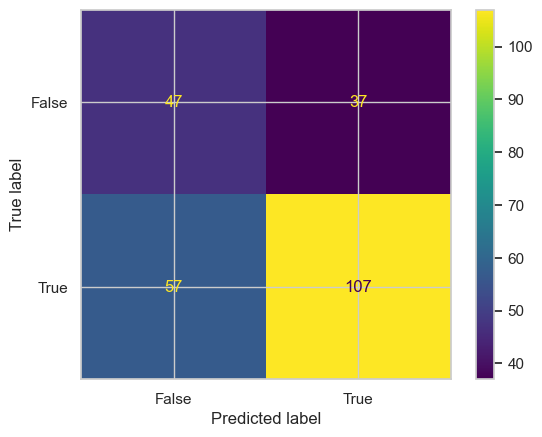

In [151]:
f1 = metrics.f1_score(df1['Y_b'], df1['Pred_qgeognn_b'], average='micro')
kappa = metrics.cohen_kappa_score(df1['Y_b'], df1['Pred_qgeognn_b'])
acc = metrics.accuracy_score(df1['Y_b'], df1['Pred_qgeognn_b'])

print('qGeoGNN')
print('F1: {}\nKAPPA: {}\nACC: {}\n'.format(f1, kappa, acc))
# print(metrics.confusion_matrix(df1['Class_b'], df1['Pred_qgeognn_b']))
print('positive: {}%, negative: {}%'.format(int(len(df1[df1['Y_b']==1])/len(df1)*100), 
                                            int(len(df1[df1['Y_b']==0])/len(df1)*100)))
confusion_matrix = metrics.confusion_matrix(df1['Y_b'], df1['Pred_qgeognn_b'])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

3DMolCSP (thr=0.5)
F1: 0.6733870967741935
KAPPA: 0.2687827606290041
AUC:0.7024535423925667
ACC: 0.6733870967741935

positive: 66%, negative: 33%


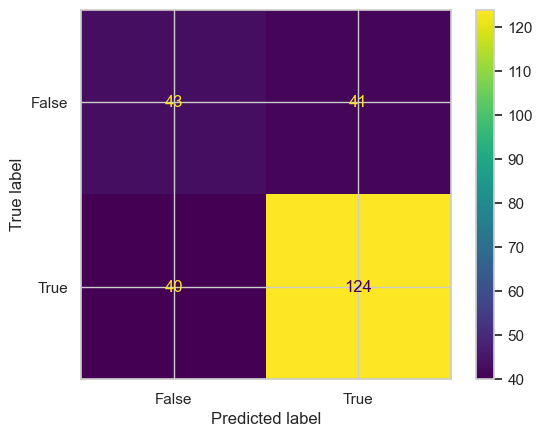

In [152]:
pred = np.array(df1.Pred_b.tolist(), dtype=float)
pred = np.where(pred > 0.5, 1, 0)
    
f1 = metrics.f1_score(pred, df1['Y_b'], average='micro')
kappa = metrics.cohen_kappa_score(pred, df1['Y_b'])
auc = metrics.roc_auc_score(df1['Y_b'], df1['Pred_b'])
acc = metrics.accuracy_score(pred, df1['Y_b'])

print('3DMolCSP (thr=0.5)')
print('F1: {}\nKAPPA: {}\nAUC:{}\nACC: {}\n'.format(f1, kappa, auc, acc))
# print(metrics.confusion_matrix(df1['Class_b'], pred))
print('positive: {}%, negative: {}%'.format(int(len(df1[df1['Y_b']==1])/len(df1)*100), 
                                            int(len(df1[df1['Y_b']==0])/len(df1)*100)))
confusion_matrix = metrics.confusion_matrix(df1['Y_b'], pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

3DMolCSP (thr=0.9)
F1: 0.6612903225806451
KAPPA: 0.2893013100436681
AUC:0.7024535423925667
ACC: 0.6612903225806451

positive: 66%, negative: 33%


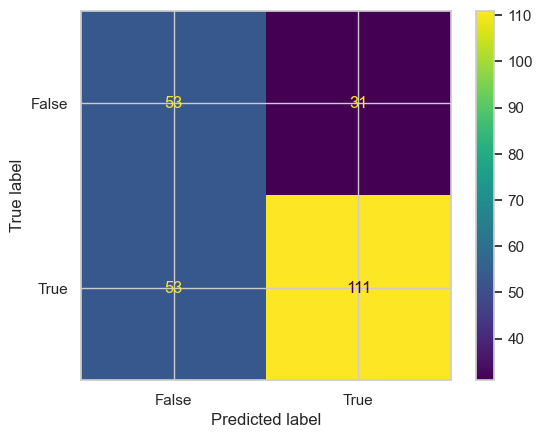

In [153]:
pred = np.array(df1.Pred_b.tolist(), dtype=float)
pred = np.where(pred > 0.9, 1, 0)

f1 = metrics.f1_score(pred, df1['Y_b'], average='micro')
kappa = metrics.cohen_kappa_score(pred, df1['Y_b'])
auc = metrics.roc_auc_score(df1['Y_b'], df1['Pred_b'])
acc = metrics.accuracy_score(pred, df1['Y_b'])

print('3DMolCSP (thr=0.9)')
print('F1: {}\nKAPPA: {}\nAUC:{}\nACC: {}\n'.format(f1, kappa, auc, acc))
# print(metrics.confusion_matrix(df1['Class_b'], pred))
print('positive: {}%, negative: {}%'.format(int(len(df1[df1['Y_b']==1])/len(df1)*100), 
                                            int(len(df1[df1['Y_b']==0])/len(df1)*100)))
confusion_matrix = metrics.confusion_matrix(df1['Y_b'], pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

Totally predicted

In [154]:
df2['RT_Pred'] = df2.apply(lambda x: x['Y_Pred'] / x['Speed'], axis=1)

df_alpha = df2.groupby('index').apply(lambda x: (x['RT'].max() - 2.9) / (x['RT'].min() -2.9)).to_frame(name='K2/K1')
df_alpha_pred = df2.groupby('index').apply(lambda x: (x['RT_Pred'].max() - 2.9) / (x['RT_Pred'].min() -2.9)).to_frame(name='K2/K1_Pred')

df2 = df_alpha.merge(df2, on='index', how='left')
df2 = df2.merge(df_alpha_pred, on='index', how='left')

In [155]:
df2 = df2.merge(df_csp, left_on='Column', right_on='Short_Name', how='left').dropna()
# df2['Y'] = df2.apply(lambda x: convert2cls(x['K2/K1'], x['CSP_Category']), axis=1)
# df2['Y_b'] = df2['Y'].apply(binary_cls)
df2['Pred_qgeognn'] = df2.apply(lambda x: convert2cls(x['K2/K1_Pred'], x['CSP_Category']), axis=1)
df2['Pred_qgeognn_b'] = df2['Pred_qgeognn'].apply(binary_cls)

df2.reset_index(drop=True, inplace=True)

In [156]:
df2['SMILES'] = df2['SMILES'].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x), isomericSmiles=False))

In [157]:
df2 = df2.merge(df_cmrt, left_on=['SMILES', 'CSP_Encode'], right_on=['SMILES', 'MB'], how='inner')

In [158]:
len(df2)

16

qGeoGNN
F1: 0.75
KAPPA: 0.5
ACC: 0.75

positive: 75%, negative: 25%


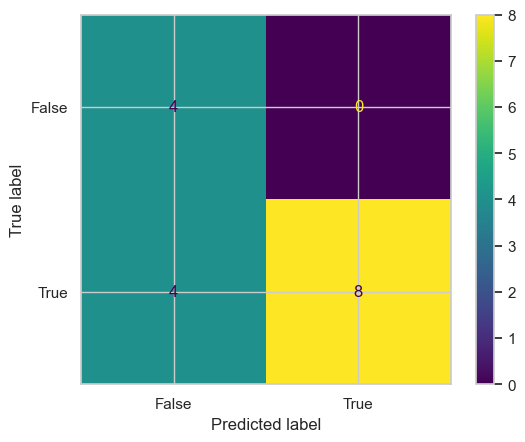

In [159]:
f1 = metrics.f1_score(df2['Y_b'], df2['Pred_qgeognn_b'], average='micro')
kappa = metrics.cohen_kappa_score(df2['Y_b'], df2['Pred_qgeognn_b'])
acc = metrics.accuracy_score(df2['Y_b'], df2['Pred_qgeognn_b'])

print('qGeoGNN')
print('F1: {}\nKAPPA: {}\nACC: {}\n'.format(f1, kappa, acc))
# print(metrics.confusion_matrix(df2['Class_b'], df2['Pred_qgeognn_b']))
print('positive: {}%, negative: {}%'.format(int(len(df2[df2['Y_b']==1])/len(df2)*100), 
                                            int(len(df2[df2['Y_b']==0])/len(df2)*100)))
confusion_matrix = metrics.confusion_matrix(df2['Y_b'], df2['Pred_qgeognn_b'])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

3DMolCSP (0.5)
F1: 0.75
KAPPA: 0.0
AUC:0.8333333333333334
ACC: 0.75

positive: 75%, negative: 25%


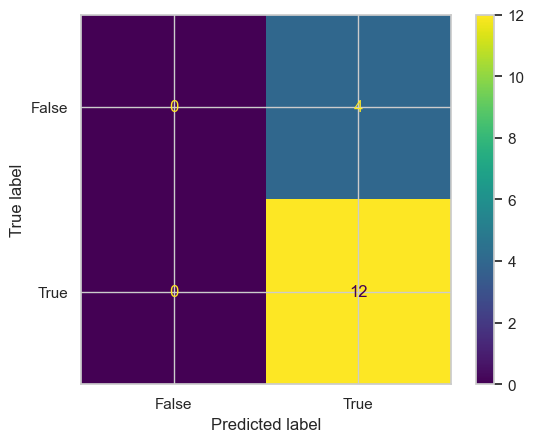

In [160]:
pred = np.array(df2.Pred_b.tolist(), dtype=float)
pred = np.where(pred > 0.5, 1, 0)
    
f1 = metrics.f1_score(pred, df2['Y_b'], average='micro')
kappa = metrics.cohen_kappa_score(pred, df2['Y_b'])
auc = metrics.roc_auc_score(df2['Y_b'], df2['Pred_b'])
acc = metrics.accuracy_score(pred, df2['Y_b'])

print('3DMolCSP (0.5)')
print('F1: {}\nKAPPA: {}\nAUC:{}\nACC: {}\n'.format(f1, kappa, auc, acc))
# print(metrics.confusion_matrix(df2['Class_b'], pred))
print('positive: {}%, negative: {}%'.format(int(len(df2[df2['Y_b']==1])/len(df2)*100), 
                                            int(len(df2[df2['Y_b']==0])/len(df2)*100)))
confusion_matrix = metrics.confusion_matrix(df2['Y_b'], pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

3DMolCSP (thr=0.9)
F1: 0.75
KAPPA: 0.0
AUC:0.8333333333333334
ACC: 0.75

positive: 75%, negative: 25%


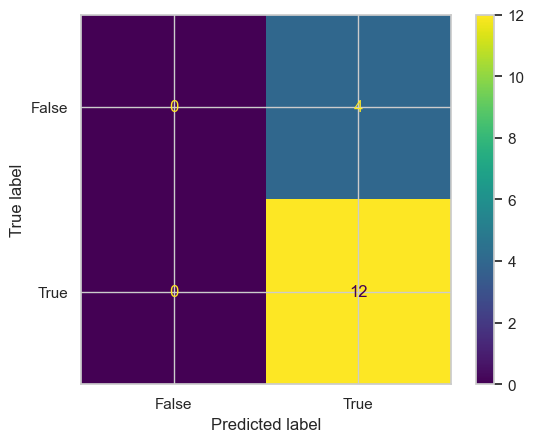

In [171]:
pred = np.array(df2.Pred_b.tolist(), dtype=float)
pred = np.where(pred > 0.9, 1, 0)
    
f1 = metrics.f1_score(pred, df2['Y_b'], average='micro')
kappa = metrics.cohen_kappa_score(pred, df2['Y_b'])
auc = metrics.roc_auc_score(df2['Y_b'], df2['Pred_b'])
acc = metrics.accuracy_score(pred, df2['Y_b'])

print('3DMolCSP (thr=0.9)')
print('F1: {}\nKAPPA: {}\nAUC:{}\nACC: {}\n'.format(f1, kappa, auc, acc))
# print(metrics.confusion_matrix(df2['Class_b'], pred))
print('positive: {}%, negative: {}%'.format(int(len(df2[df2['Y_b']==1])/len(df2)*100), 
                                            int(len(df2[df2['Y_b']==0])/len(df2)*100)))
confusion_matrix = metrics.confusion_matrix(df2['Y_b'], pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

All 

In [162]:
df_all = pd.concat([df1[['Y_b', 'Pred_qgeognn_b', 'Pred_b']],
                  df2[['Y_b', 'Pred_qgeognn_b', 'Pred_b']]])

In [163]:
len(df_all)

264

qGeoGNN
F1: 0.6287878787878788
KAPPA: 0.21808510638297873
ACC: 0.6287878787878788

positive: 66%, negative: 33%


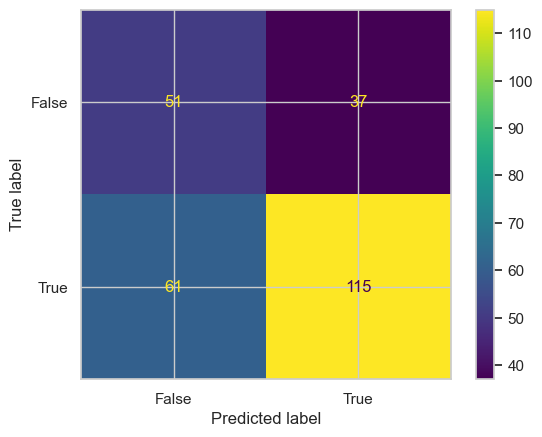

In [164]:
f1 = metrics.f1_score(df_all['Y_b'], df_all['Pred_qgeognn_b'], average='micro')
kappa = metrics.cohen_kappa_score(df_all['Y_b'], df_all['Pred_qgeognn_b'])
acc = metrics.accuracy_score(df_all['Y_b'], df_all['Pred_qgeognn_b'])

print('qGeoGNN')
print('F1: {}\nKAPPA: {}\nACC: {}\n'.format(f1, kappa, acc))
# print(metrics.confusion_matrix(df_all['Class_b'], df_all['Pred_qgeognn_b']))
print('positive: {}%, negative: {}%'.format(int(len(df_all[df_all['Y_b']==1])/len(df_all)*100), 
                                            int(len(df_all[df_all['Y_b']==0])/len(df_all)*100)))
confusion_matrix = metrics.confusion_matrix(df_all['Y_b'], df_all['Pred_qgeognn_b'])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

3DMolCSP (thr=0.5)
F1: 0.678030303030303
KAPPA: 0.26512968299711814
AUC:0.7031895661157025
ACC: 0.678030303030303

positive: 66%, negative: 33%


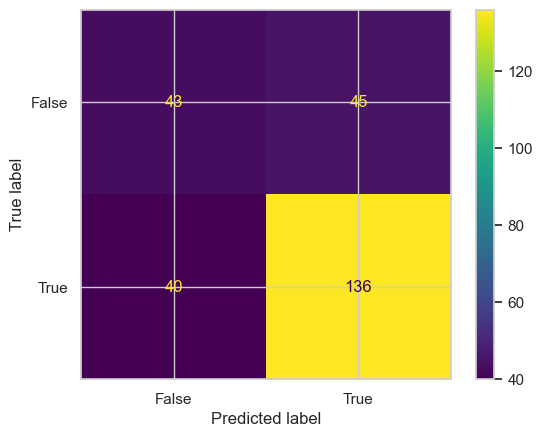

In [165]:
pred = np.array(df_all.Pred_b.tolist(), dtype=float)
pred = np.where(pred > 0.5, 1, 0)

f1 = metrics.f1_score(pred, df_all['Y_b'], average='micro')
kappa = metrics.cohen_kappa_score(pred, df_all['Y_b'])
auc = metrics.roc_auc_score(df_all['Y_b'], df_all['Pred_b'])
acc = metrics.accuracy_score(pred, df_all['Y_b'])

print('3DMolCSP (thr=0.5)')
print('F1: {}\nKAPPA: {}\nAUC:{}\nACC: {}\n'.format(f1, kappa, auc, acc))
# print(metrics.confusion_matrix(df_all['Class_b'], pred))
print('positive: {}%, negative: {}%'.format(int(len(df_all[df_all['Y_b']==1])/len(df_all)*100), 
                                            int(len(df_all[df_all['Y_b']==0])/len(df_all)*100)))
confusion_matrix = metrics.confusion_matrix(df_all['Y_b'], pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

3DMolCSP (thr=0.9)
F1: 0.6666666666666666
KAPPA: 0.297872340425532
AUC:0.7031895661157025
ACC: 0.6666666666666666

positive: 66%, negative: 33%


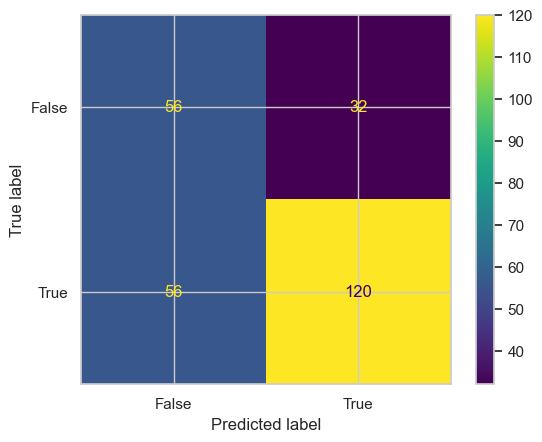

In [168]:
pred = np.array(df_all.Pred_b.tolist(), dtype=float)
pred = np.where(pred > 0.9, 1, 0)

f1 = metrics.f1_score(pred, df_all['Y_b'], average='micro')
kappa = metrics.cohen_kappa_score(pred, df_all['Y_b'])
auc = metrics.roc_auc_score(df_all['Y_b'], df_all['Pred_b'])
acc = metrics.accuracy_score(pred, df_all['Y_b'])

print('3DMolCSP (thr=0.9)')
print('F1: {}\nKAPPA: {}\nAUC:{}\nACC: {}\n'.format(f1, kappa, auc, acc))
# print(metrics.confusion_matrix(df_all['Class_b'], pred))
print('positive: {}%, negative: {}%'.format(int(len(df_all[df_all['Y_b']==1])/len(df_all)*100), 
                                            int(len(df_all[df_all['Y_b']==0])/len(df_all)*100)))
confusion_matrix = metrics.confusion_matrix(df_all['Y_b'], pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()